# Player Analysis
In this Jupyter notebook, I utilize FPL player data from 2024-2025 to dig deeper into top performers and the value of different positions within the game.

In [3]:
import pandas as pd
import requests, json
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

In [4]:
players_weekly_df = pd.read_csv('player_weekly_history.csv')

#add in opponent_team name
fpl_api_url = 'https://fantasy.premierleague.com/api/'

# get data from bootstrap-static endpoint
r = requests.get(fpl_api_url+'bootstrap-static/').json()
# create teams dataframe 
teams = pd.json_normalize(r['teams'])
teams = teams[['name', 'id']]

# merge in opponent team names
players_weekly_df = pd.merge(
    left=players_weekly_df,
    right=teams,
    left_on='opponent_team',
    right_on='id'
)

# drop columns not of interest and rename ambiguous column names
players_weekly_df = players_weekly_df.drop(players_weekly_df.columns[0], axis=1)
players_weekly_df = players_weekly_df.drop(columns=['id', 'mng_win', 'mng_draw', 'mng_loss', 'mng_underdog_win', 'mng_underdog_draw', 'mng_clean_sheets', 'mng_goals_scored'])
players_weekly_df = players_weekly_df.rename(columns={'opponent_team': 'opponent_team_id', 
                                          'name': 'opponent_team_name'})
players_weekly_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20217 entries, 0 to 20216
Data columns (total 42 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   element                     20217 non-null  int64  
 1   fixture                     20217 non-null  int64  
 2   opponent_team_id            20217 non-null  int64  
 3   total_points                20217 non-null  int64  
 4   was_home                    20217 non-null  bool   
 5   kickoff_time                20217 non-null  object 
 6   team_h_score                20217 non-null  int64  
 7   team_a_score                20217 non-null  int64  
 8   round                       20217 non-null  int64  
 9   modified                    20217 non-null  bool   
 10  minutes                     20217 non-null  int64  
 11  goals_scored                20217 non-null  int64  
 12  assists                     20217 non-null  int64  
 13  clean_sheets                202

In [5]:
# create summary df, aggregating weekly statistics
#add in appeared column to aggregate number of appearances
players_weekly_df['appeared'] = [1 if minutes > 0  else 0 for minutes in players_weekly_df['minutes']]
players_weekly_df['goals_conceded_deductions'] = 0
players_weekly_df.loc[players_weekly_df.position == 'Goalkeeper', 'goals_conceded_deductions'] = players_weekly_df['goals_conceded'] % 2
players_weekly_df.loc[players_weekly_df.position == 'Defender', 'goals_conceded_deductions'] = players_weekly_df['goals_conceded'] % 2

#set list of columns to aggregate by, removing columns that don't make sense to sum (i.e. fixture, kickoff_time, etc.) 
sum_columns = players_weekly_df.columns.to_list()
remove_columns = ['Unnamed: 0', 'fixture', 'opponent_team_id', 'was_home', 'kickoff_time', 'team_h_score', 'team_a_score', 'round', 'modified',  'player_id', 'player_name', 'team_name', 'position', 'opponent_team_name']
sum_columns = [col for col in sum_columns if col not in remove_columns]

players_total_df = players_weekly_df.groupby('player_id')[sum_columns].sum().reset_index()

#add in identifying position information
join_df = players_weekly_df[['player_name', 'position', 'player_id', 'team_name']].drop_duplicates()
players_total_df = players_total_df.join(join_df.set_index('player_id'), on='player_id')

#rename columns to be more descriptive for summary df
players_total_df = players_total_df.rename(columns={'value': 'total_value', 
                                          'appeared': 'total_appearances'})
#add in aggregate statistics -- points_per_appearance, points_per_round, points_per_90, avg_weekly_value, avg_minutes_per_appearance
players_total_df['points_per_appearance'] = players_total_df['total_points']/players_total_df['total_appearances']
players_total_df['points_per_round'] = players_total_df['total_points']/38
players_total_df['points_per_90'] = (players_total_df['total_points']/players_total_df['minutes'])*90
players_total_df['avg_minutes_per_appearance'] = players_total_df['minutes']/players_total_df['total_appearances']
players_total_df['avg_weekly_value'] = (players_total_df['total_value'])/38

#top total points performers
players_total_df = players_total_df.sort_values(by='total_points', ascending=False)
display_columns = ['player_name', 'team_name', 'position', 'total_points', 'points_per_appearance']
print('Top Total Points Performers:')
display(players_total_df[display_columns].head())

print('')
print('Top Points per Appearance Performers:')
players_total_df = players_total_df.sort_values(by='points_per_appearance', ascending=False)
display(players_total_df[display_columns].head())

Top Total Points Performers:


,player_name,team_name,position,total_points,points_per_appearance
253,Mohamed Salah,Liverpool,Midfielder,344,9.052632
77,Bryan Mbeumo,Brentford,Midfielder,236,6.210526
132,Cole Palmer,Chelsea,Midfielder,214,5.783784
314,Alexander Isak,Newcastle,Forward,211,6.205882
344,Chris Wood,Nott'm Forest,Forward,200,5.555556



Top Points per Appearance Performers:


,player_name,team_name,position,total_points,points_per_appearance
253,Mohamed Salah,Liverpool,Midfielder,344,9.052632
77,Bryan Mbeumo,Brentford,Midfielder,236,6.210526
314,Alexander Isak,Newcastle,Forward,211,6.205882
271,Erling Haaland,Man City,Forward,181,5.838710
132,Cole Palmer,Chelsea,Midfielder,214,5.783784


The top points getters are all midfielders and forwards. Let's get a sense of the spread of total_points by position with box plots.

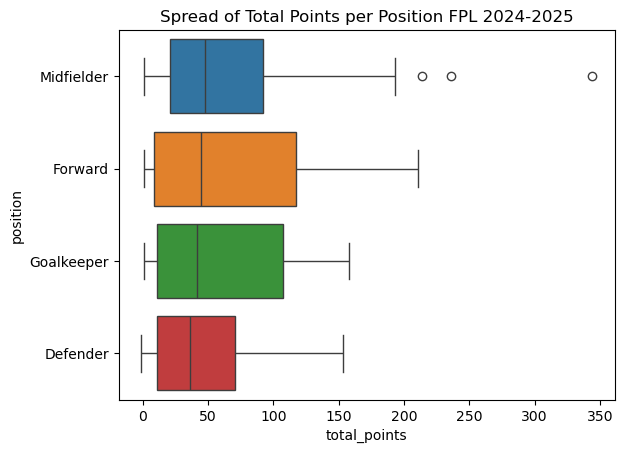

<Figure size 640x480 with 0 Axes>

In [10]:
sns.boxplot(data=players_total_df, x='total_points', y='position', hue='position')
plt.title('Spread of Total Points per Position FPL 2024-2025')
plt.show()
plt.clf()

The results are a little surprising -- from these boxplots, it's clear that Mohammed Salah, Bryan Mbeumo, and Cole Palmer are outliers. There is not much variation in the median values of the four categories but the third quartiles for both Forward and Goalkeeper are higher than those for midfield. Forwards and Goalkeepers seem to be similar in that they have generally lower floors but also generally higher ceilings than midfielders. Let's see how things look when we look at points per appearance instead!

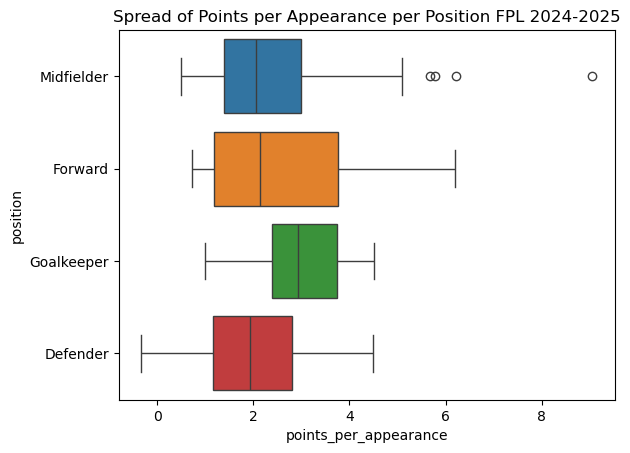

<Figure size 640x480 with 0 Axes>

In [13]:
sns.boxplot(data=players_total_df, x='points_per_appearance', y='position', hue='position')
plt.title('Spread of Points per Appearance per Position FPL 2024-2025')
plt.show()
plt.clf()

Goalkeepers emerge as even stronger performers! However, this is likely due to how points are awarded based on minutes played. A player can earns 1 point for starting a match and playing up to 60 of the 90 minutes. They then get an addtional 2 points (for a total of 3) if they play past that 60 minute threshold. Goalkeepers are rarely substituted (often only in the case of injury) meaning that if they start, and they don't have a catastrophic day, they're usually good for at least 3 points. Let's see if this bears out by looking at the spread of average minutes per appearance.

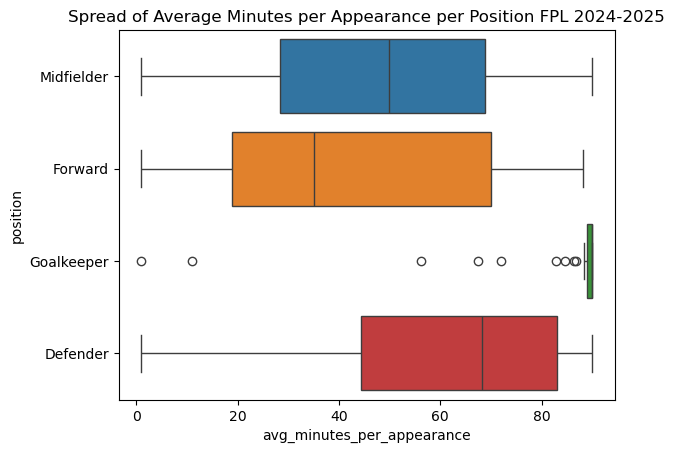

<Figure size 640x480 with 0 Axes>

In [16]:
sns.boxplot(data=players_total_df, x='avg_minutes_per_appearance', y='position', hue='position')
plt.title('Spread of Average Minutes per Appearance per Position FPL 2024-2025')
plt.show()
plt.clf()

Playing anything less than 85 minutes in an appearance for a goalkeeper is considered an outlier! Now let's dive more into our lowly defenders and explore whether the points system is actually disadvantageous to them.

In FPL, players can only lose points for a handful of circumstances -- missing a penalty (-2), conceding 2 goals if you are a defender or goalkeeper (-1 for every set of 2 goals conceded in a match, i.e. -2 if your team conceded 4 goals in a match), receiving a yellow card (-1), receiving a red card (-3), and scoring an own goal (-2). On its face, these points deductions would seem to focus more on punishing defensive mistakes. But, let's investigate who is actually bearing the brunt of these deductions.

In [22]:
deductions_by_position = players_total_df.groupby('position')[['penalties_missed', 'own_goals', 'yellow_cards', 'red_cards', 'goals_conceded_deductions']].sum()
deductions_by_position['total_points_deducted'] = deductions_by_position['penalties_missed']*2 + deductions_by_position['own_goals']*2 + deductions_by_position['yellow_cards']*1 + deductions_by_position['red_cards']*3 + deductions_by_position['goals_conceded_deductions']
deductions_by_position['total_players_per position'] = players_total_df.groupby('position')['player_id'].count()
deductions_by_position['avg_deduction_total_season'] = round(deductions_by_position['total_points_deducted'] / deductions_by_position['total_players_per position'], 2)
deductions_by_position = deductions_by_position.sort_values(by='avg_deduction_total_season', ascending=False)
display(deductions_by_position)

,penalties_missed,own_goals,yellow_cards,red_cards,goals_conceded_deductions,total_points_deducted,total_players_per position,avg_deduction_total_season
position,,,,,,,,
Defender,0,25,573,21,1562,2248,198,11.35
Goalkeeper,0,1,60,1,345,410,44,9.32
Midfielder,9,7,787,25,0,894,257,3.48
Forward,5,1,127,5,0,154,63,2.44


Clearly defensive positions suffer most heavily from points deductions. Let's now see who can most reliably get awarded points.